In [1]:
%load_ext autoreload
%autoreload 2
import sys
dirr = "../../src"
if dirr not in sys.path:
    sys.path.append(dirr)
%xmode Plain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils as helper

Exception reporting mode: Plain


In [2]:
data = pd.read_csv("../../data/tennis/tennis.csv")
data.head(3)

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes


---
## Question 1
**a) and b)** Using Parallelism internally by the use of ``Pool`` in ``multiprocessing`` library. Look at ``rf.py`` for the exact details.

In [3]:
from rf import RandomForestClassifier

In [4]:
rf = RandomForestClassifier(max_depth=2, num_of_trees=3, jobs=2)
rf.train(data)

In [5]:
data.head(7)

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes


In [14]:
rf.predict(data.iloc[:7, :-1])

,0
0,yes
1,yes
2,yes
3,yes
4,yes
5,yes
6,yes


In [15]:
rf.preds

,0,0,0
0,yes,yes,yes
1,yes,yes,yes
2,yes,yes,yes
3,yes,yes,yes
4,yes,yes,yes
5,yes,yes,yes
6,yes,yes,yes


In [8]:
for dt_roots in rf.roots:
    print (helper.parser(dt_roots))

Question: Is 1th Column = overcast
  T: Predict: yes
  F: Question: Is 0th Column = high
    T: Predict: no
    F: Predict: yes

Question: Is 0th Column = overcast
  T: Predict: yes
  F: Question: Is 1th Column = high
    T: Predict: no
    F: Predict: yes

Question: Is 0th Column = overcast
  T: Predict: yes
  F: Question: Is 2th Column = hot
    T: Predict: no
    F: Predict: yes



---
## Question 1
**c)** Below are the plot representing the change in performance with increase in jobs.

In [27]:
from sklearn.model_selection import train_test_split
import time
def timer(data, jobs, num):
    rf = RandomForestClassifier(method = 'gini',
                                max_depth=2,
                                jobs=jobs,
                                num_of_trees=num)
    dTrain, dTest = train_test_split(data, test_size=.3)
    start = time.time()
    rf.train(dTrain)
    end = time.time()
    train = end-start
    start = time.time()
    rf.predict(dTest.iloc[:, :-1])
    end = time.time()
    test = end-start
    return train, test

In [28]:
# timing with # of jobs
tr, ts = [], []
for job in range(1, 5):
    train, test = timer(data, job, num=5) # training 5 trees
    tr.append(train)
    ts.append(test)

In training we see there is marginal (my cpu isn't powerfull) increase in preformance

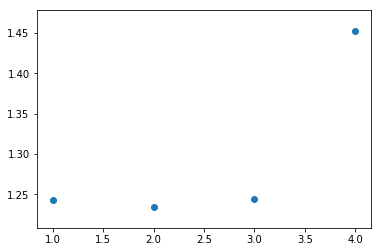

In [29]:
# plot training time w.r.t. # of jobs
plt.scatter(range(1, 5), tr)

In Prediction we see that there doesn't seem to be any improvement in performance

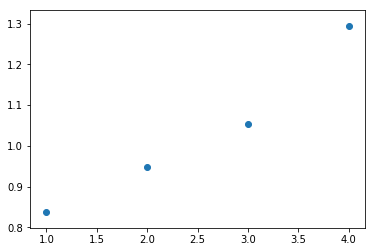

In [30]:
# plot predicition time w.r.t. # of jobs
plt.scatter(range(1, 5), ts)

---
## Question 1
**d)** Using RF on IRIS data set.

---
## Question 1
**e)** Using 5 fold cross-validation on IRIS dataset.

---
## Question 4
Generating a dataset with random noise as Gaussian Distribution.

In [ ]:
def dataset_generator(m, c, samples = 50, sigma=10): 
    """assumes random noise comes from
    Gaussian Distribution
    """
    X = np.arange(samples)
    random_noise = np.random.normal(scale=sigma, size=samples)
    Y = m*X + c + random_noise
    return X, Y

In [ ]:
X, Y = dataset_generator(m=2, c=43, samples=50, sigma=10)
plt.scatter(X, Y)

---
## Question 5
Look at the code in ``utils.py`` for the algorithm used. Basically I used Linear congruential generator.

In [ ]:
import utils as helper
y = helper.random_list(N = 100, samples = 10000)
plt.hist(y)